# Betti Curves from Networkx
This notebook expands what is taught in:
- https://www.youtube.com/watch?v=p-JytikcNB0&ab_channel=Rapha%C3%ABlTinarrage
- https://github.com/raphaeltinarrage/EMAp/blob/main/Tutorial2.ipynb
<br>
The above material explains how to create Betti Curves from point clouds. Here I use the provided code with some adjustments to create Betti Curves from networks (distance matrix).
<br><br>
<b>About Betti numbers/curve:</b>
"Betti numbers demonstrate the number of k-dimensional topological holes". This paper uses Betti curve to differentiate health samples from cancer samples: https://www.nature.com/articles/s41598-021-94847-5

In [1]:
import numpy as np
import pandas as pd
import gudhi  
import matplotlib.pyplot as plt
import networkx as nx

# 1 - Create 4 samples (toys) networks with NetworkX

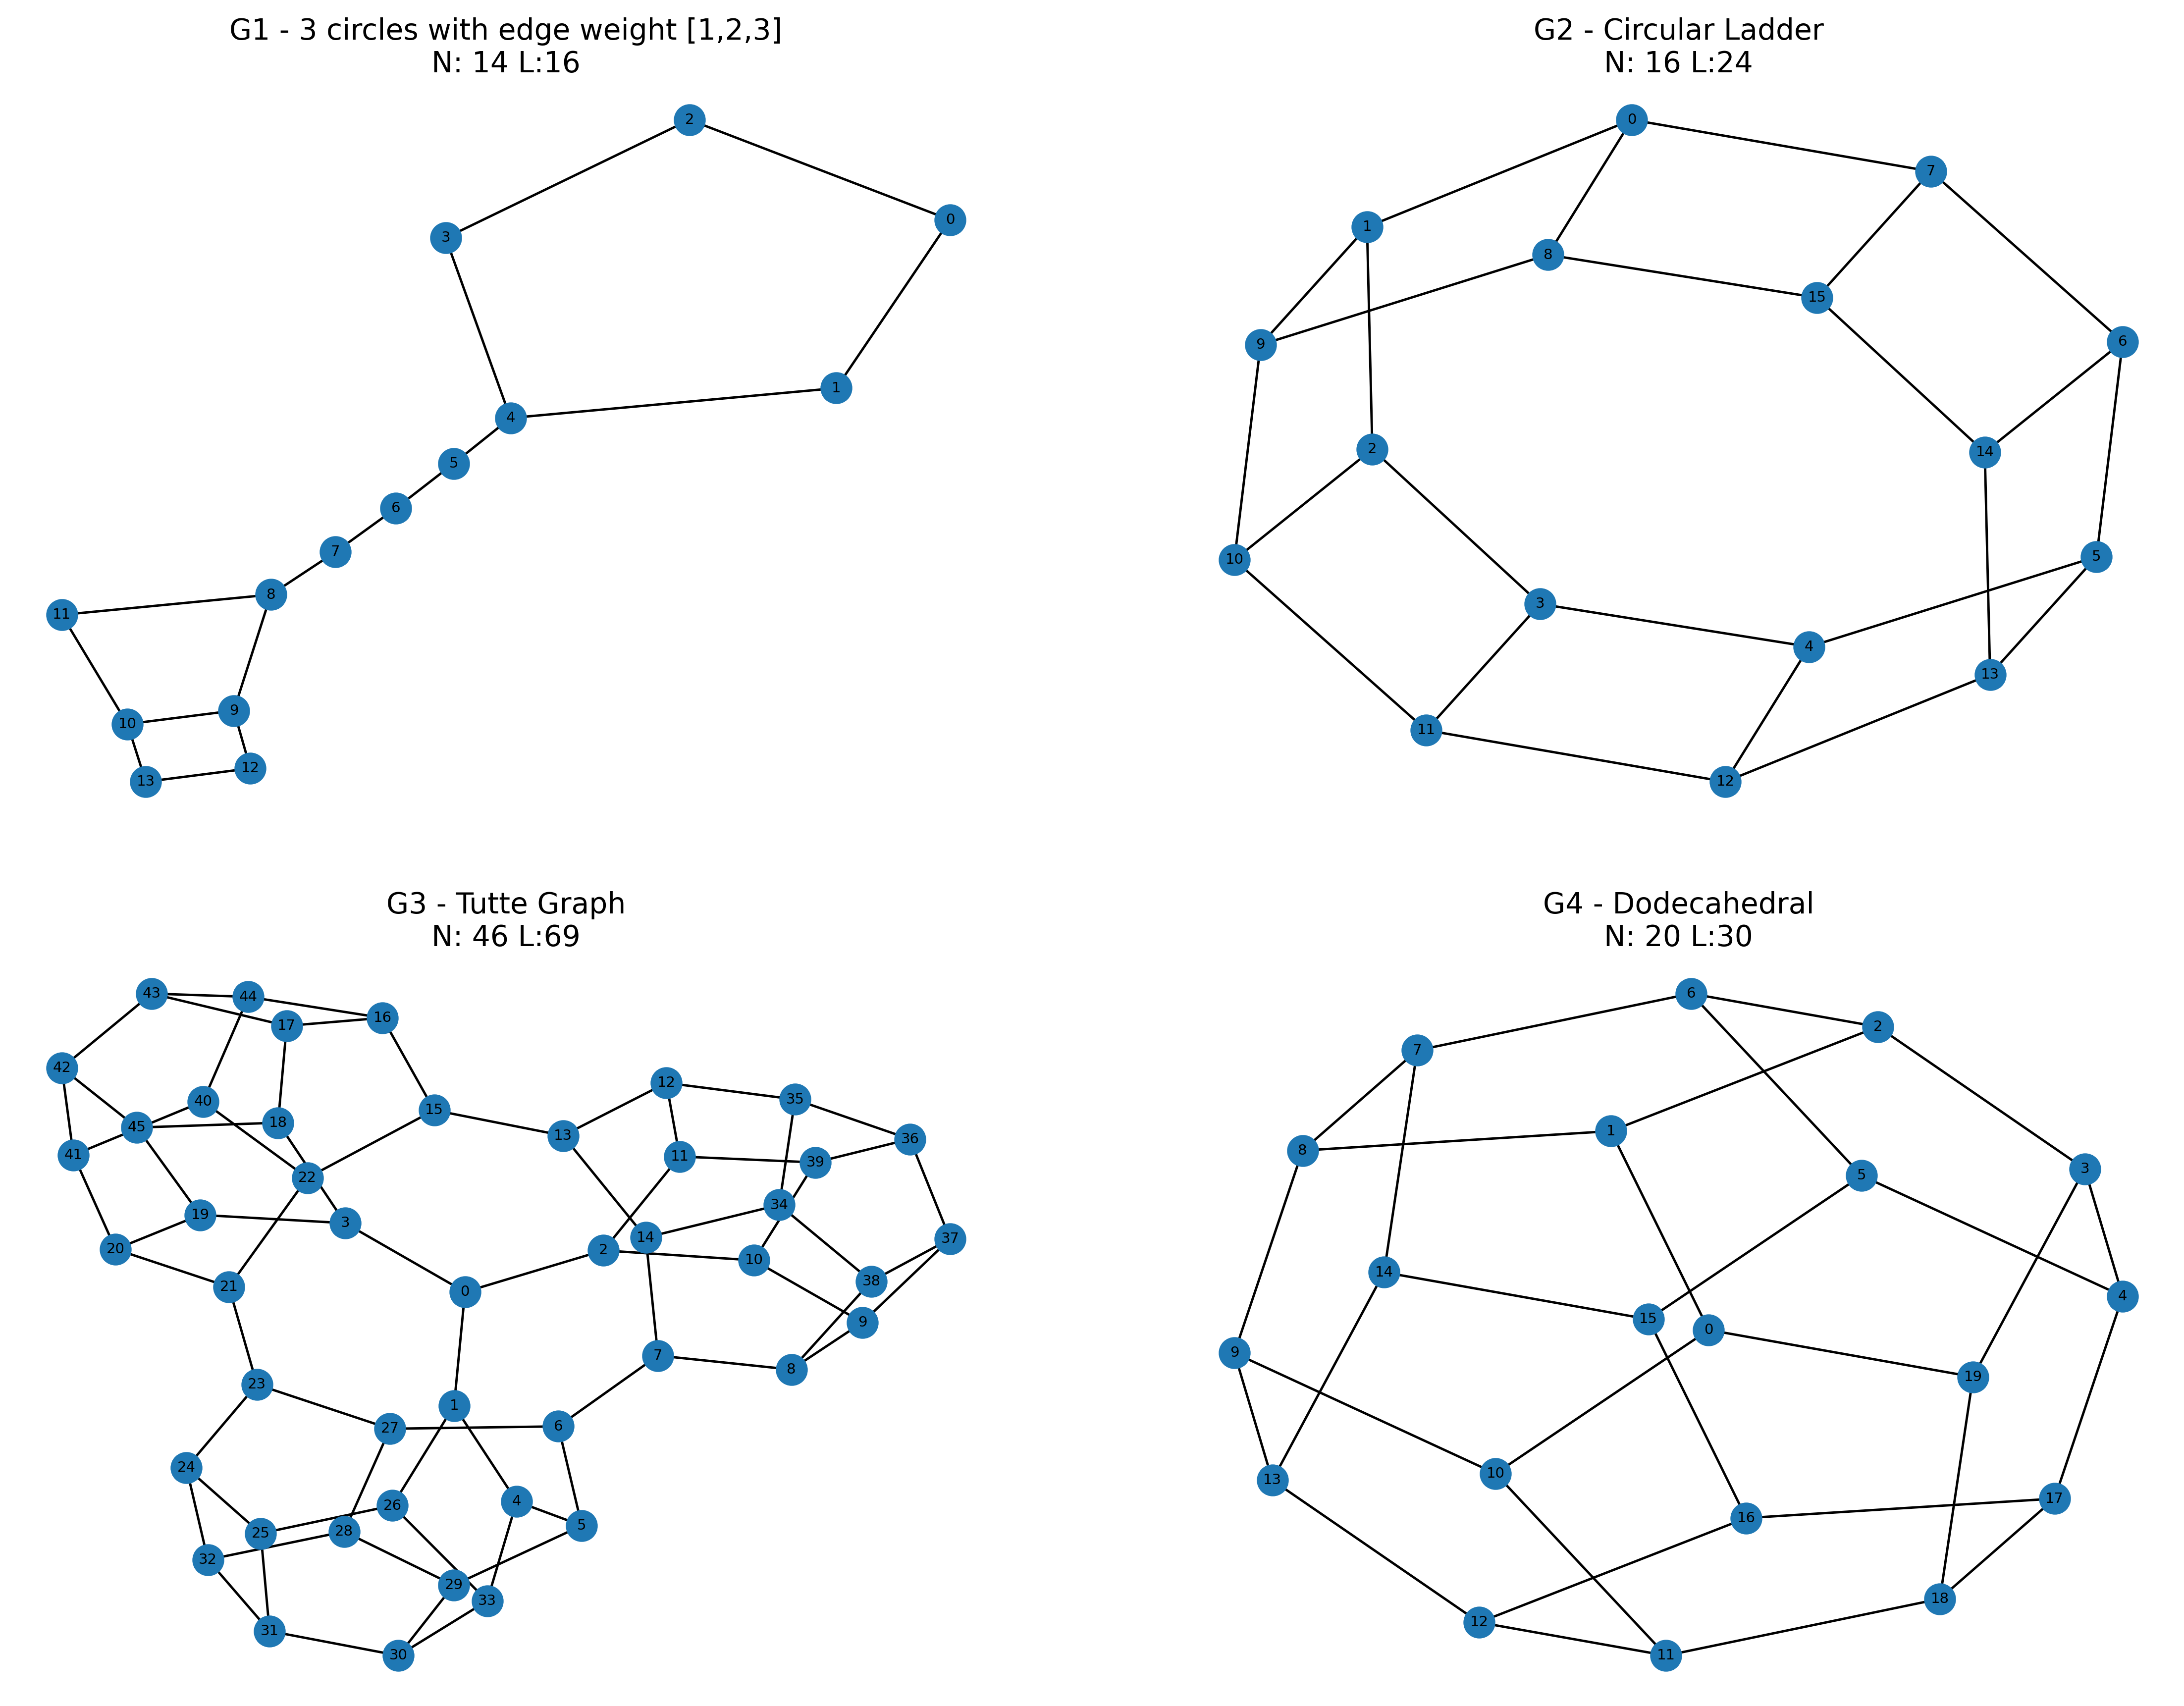

In [2]:
G1 = nx.barbell_graph(5,3)
G1.remove_edges_from([(2,4),(3,1),(1,2),(3,0),(0,4)])
G1.remove_edges_from([(8,10),(8,12),(11,9),(11,12),(0,4),(10,12)])
G1.add_edges_from([(0,1), (0,2), (2, 3), (3, 4), (4, 1)], weight=3)
G1.add_edges_from([(8,9), (9,10), (10, 11), (11, 8)], weight=2)
G1.add_edges_from([(9,12), (9,10), (10, 13),(12,13)], weight=1)
G1.name='G1 - 3 circles with edge weight [1,2,3]'

# G1=nx.Graph()
# G1.add_edges_from([(0,1), (1,2), (2, 3), (3, 4), (4, 0)], weight=2)
# G1.name='G1 - Barbell (Circle weight=2)'

G2 = nx.generators.circular_ladder_graph(8)
G2.name='G2 - Circular Ladder'

G3 = nx.tutte_graph()
G3.name='G3 - Tutte Graph'

G4 = nx.generators.dodecahedral_graph()
G4.name='G4 - Dodecahedral'

#-----Ploting

plt.figure(figsize=(16,12),dpi=350)
for i,G in enumerate([G1,G2,G3,G4]):
    plt.subplot(2,2,i+1)
    plt.title(G.name+'\nN: '+str(G.number_of_nodes())+' L:'+str(G.number_of_edges()))
    nx.draw_kamada_kawai(G,with_labels=True,node_size=150,font_size=6)
plt.show()

# 2 - Calculate the Distance Matrix for these networks

In [3]:
%%time
networks={}
distanceMatrixs={}
for G in [G1,G2,G3,G4]:
    distanceMatrixs[G.name]=pd.DataFrame(dict(nx.shortest_path_length(G,weight='weight'))).sort_index()
    networks[G.name]=G

CPU times: total: 15.6 ms
Wall time: 24 ms


# 3 - Create de Betti Curve

In [4]:
# Orignal Function reference: https://github.com/raphaeltinarrage/EMAp/blob/main/Tutorial2.ipynb
def GetBettiCurvesFromDistancesOriginal(D, J, dim=2):
    '''
    Computes the Betti curves of the Rips complex of the distance matrix D, 
    on the interval J, up to dimension dim.

    Input:
        X (np.array): size Nx?, the distance matrix.
        J (np.array): interval. Shape 1xM. 
        dim (int, optional): maximal dimension to compute the Betti curves. 
    
    Output:
        BettiCurves (np.array): the Betti curves. Shape (dim+1)xM. The ith 
                                Betti curve is given by BettiCurve[i,:].  

    Example:
        D = np.asarray([[0,1,2],[1,0,3],[2,3,0]])
        J = np.linspace(0,1,100)
        GetBettiCurvesFromDistances(D, J, dim = 1)
    '''
    I = 2*J
    tmax = max(I)
    rips = gudhi.RipsComplex(distance_matrix = D, max_edge_length = tmax)
    st = rips.create_simplex_tree(max_dimension=dim)
    st.persistence(persistence_dim_max=True, homology_coeff_field = 2)
    Diagrams = [st.persistence_intervals_in_dimension(i) for i in range(dim+1)]
    BettiCurves = []
    step_x = I[1]-I[0]
    for diagram in Diagrams:
        bc =  np.zeros(len(I))
        if diagram.size != 0:
            diagram_int = np.clip(np.ceil((diagram[:,:2] - I[0]) / step_x), 0, len(I)).astype(int)
            for interval in diagram_int:
                bc[interval[0]:interval[1]] += 1
        BettiCurves.append(np.reshape(bc,[1,-1]))
    return np.reshape(BettiCurves, (dim+1, len(I)))


def GetBettiCurvesFromDistancesRefactoring (D, dim=2):
    '''
        The difference between the original version an this one is the dynamic calculation of the interval
    '''
    rips = gudhi.RipsComplex(distance_matrix = D)
    st = rips.create_simplex_tree(max_dimension=dim)
    st.persistence()

    #Dynamically calculate the interval
    values=[]
    for i in range(dim+1):
        values.extend(st.persistence_intervals_in_dimension(i).ravel())
    values.sort()
    I = np.linspace(0,values[-2]+1,100)

    Diagrams = [st.persistence_intervals_in_dimension(i) for i in range(dim+1)]
    BettiCurves = []
    step_x = I[1]-I[0]
    for diagram in Diagrams:
        bc =  np.zeros(len(I))
        if diagram.size != 0:
            diagram_int = np.clip(np.ceil((diagram[:,:2] - I[0]) / step_x), 0, len(I)).astype(int)
            for interval in diagram_int:
                bc[interval[0]:interval[1]] += 1
        BettiCurves.append(np.reshape(bc,[1,-1]))
    return I,np.reshape(BettiCurves, (dim+1, len(I)))

The G1 network has 3 cycles, but the  1-Betti Curves show only one cycles that live for 3 steps. This happens because each cycle has increasing edge weight, and as one dies, the other is born. This gives the wrong idea of one great cycle.


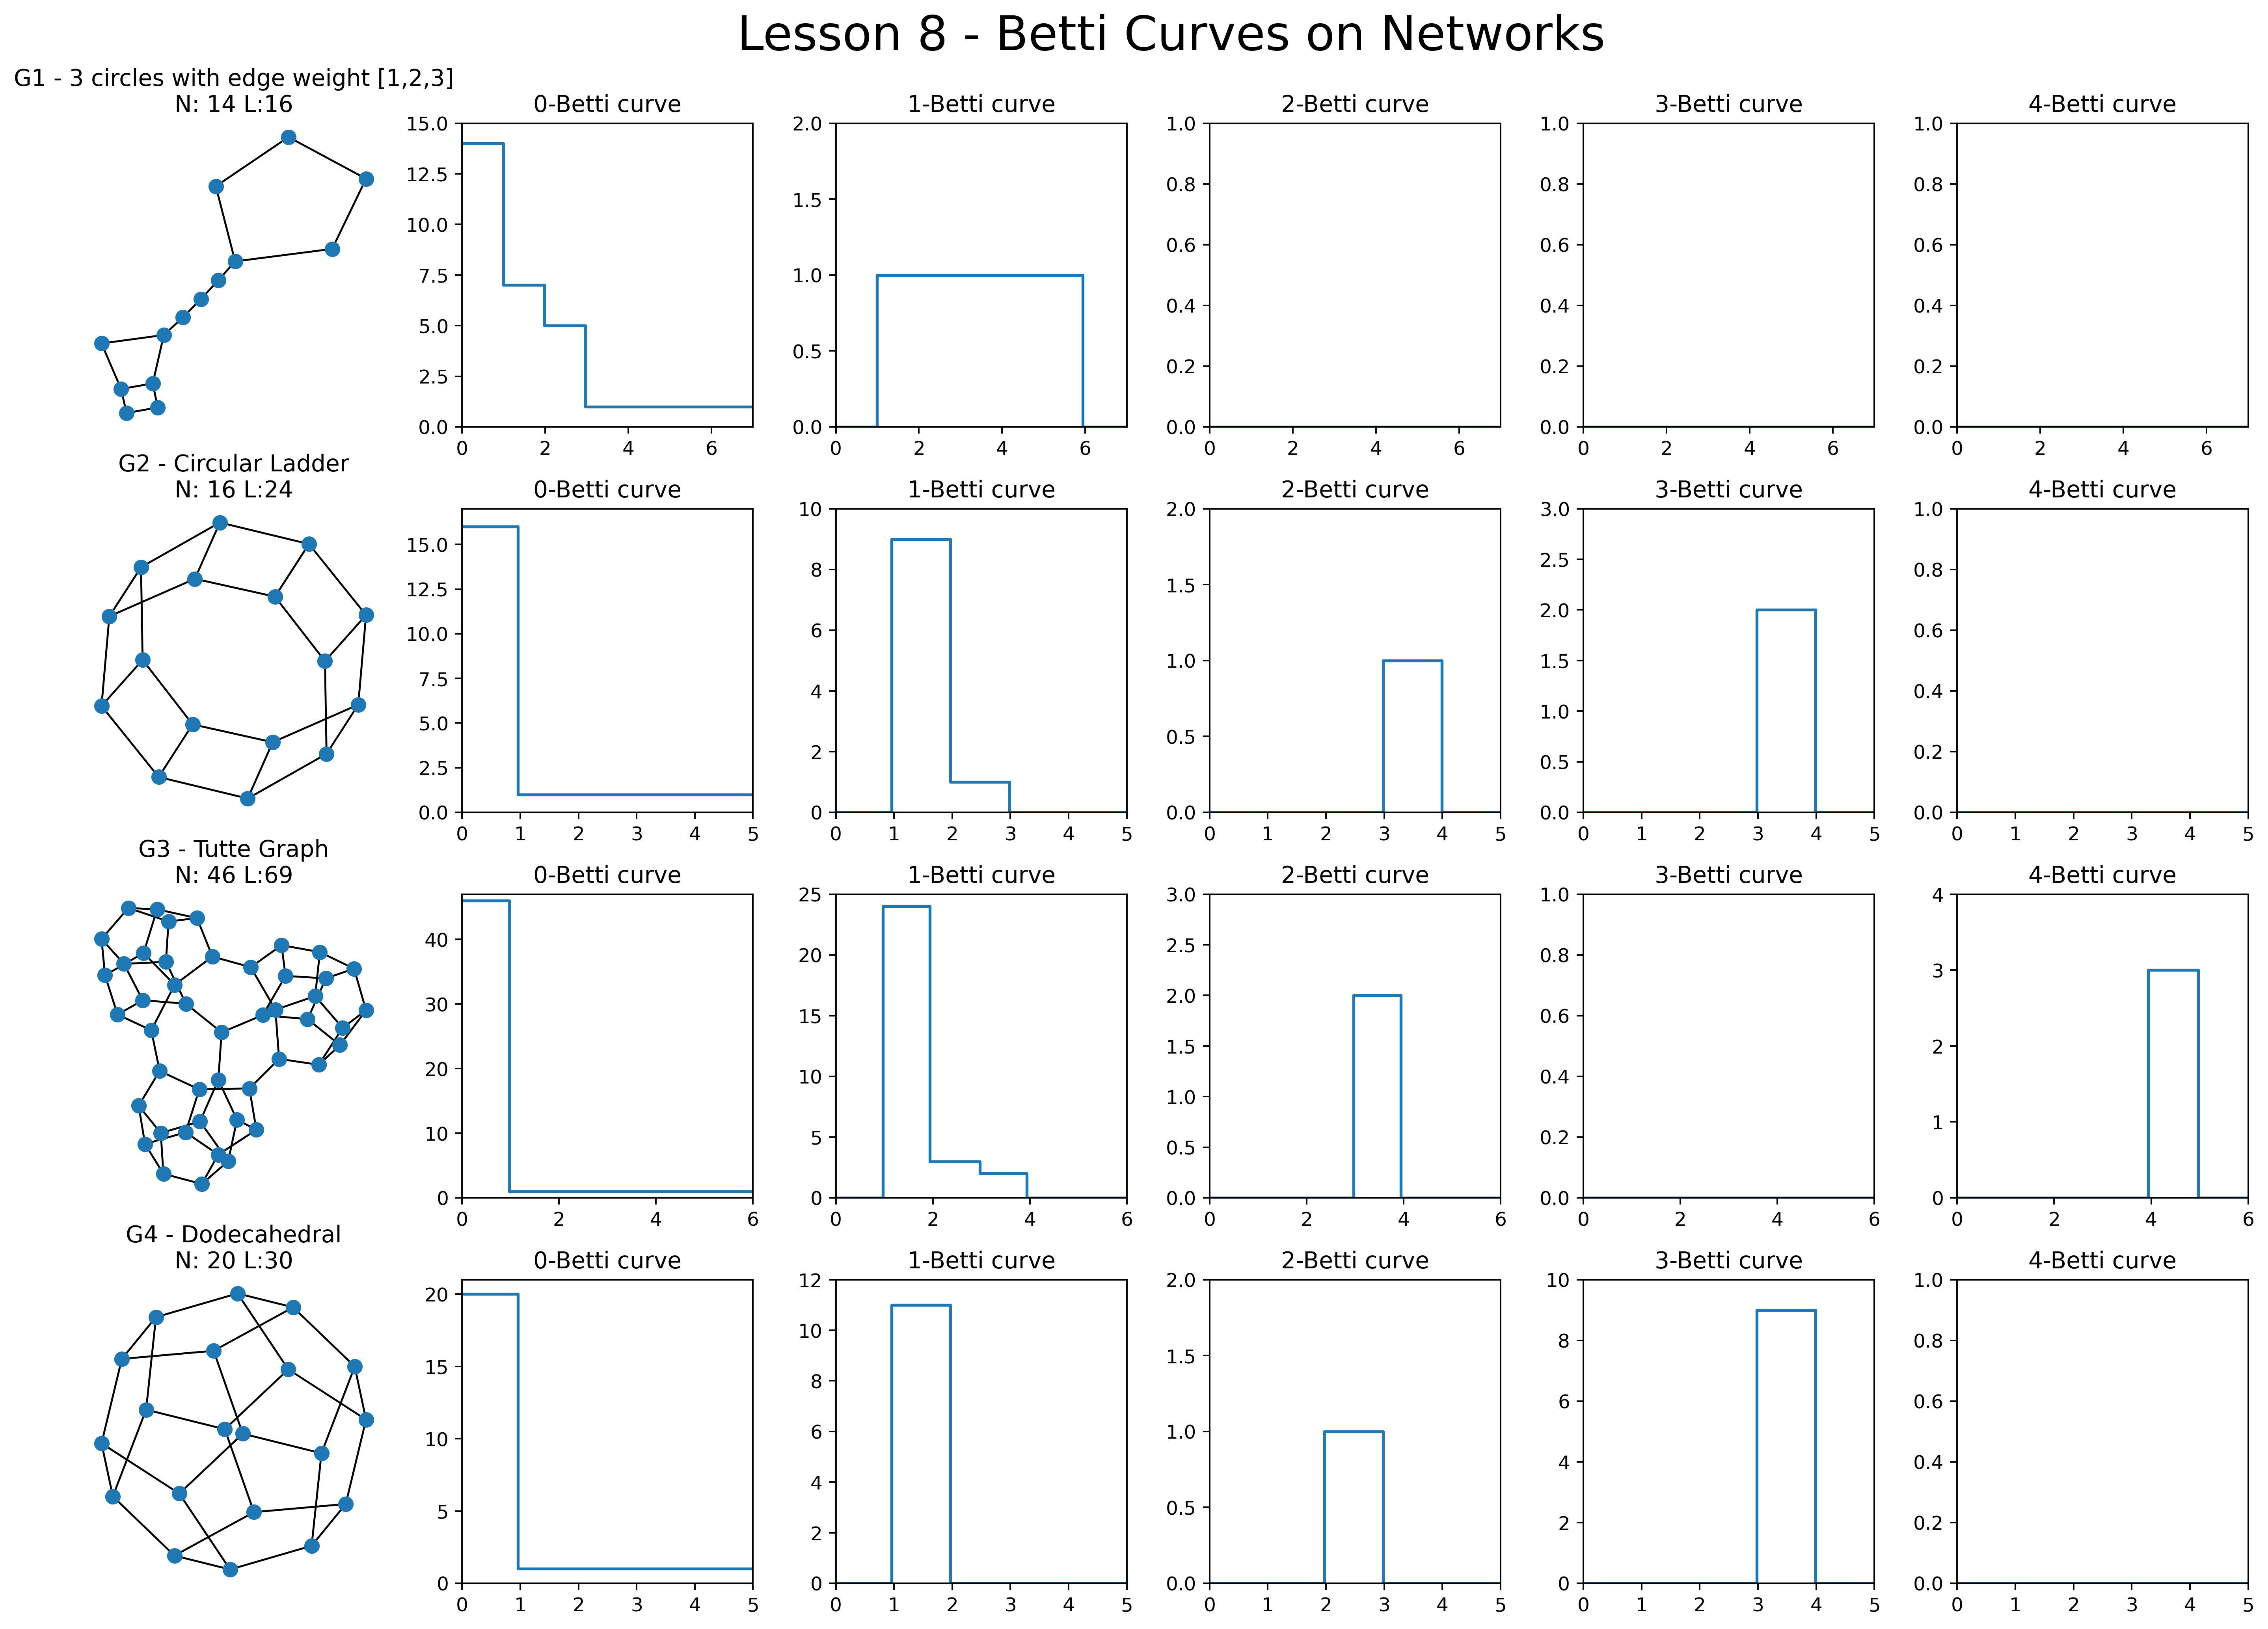

CPU times: total: 38.3 s
Wall time: 38.3 s


In [5]:
%%time

print('The G1 network has 3 cycles, but the  1-Betti Curves show only one cycles that live for 3 steps. This happens because each cycle has increasing edge weight, and as one dies, the other is born. This gives the wrong idea of one great cycle.')

dim=5
interval = np.linspace(0,10,100)

plt.figure(figsize=(16,12),dpi=350)
i=1
for G in [G1,G2,G3,G4]:
    interval, Betti_curves = GetBettiCurvesFromDistancesRefactoring(distanceMatrixs[G.name].values, dim) 
        
    plt.subplot(4,dim+1,i)        
    plt.title(G.name+'\nN: '+str(G.number_of_nodes())+' L:'+str(G.number_of_edges()))
    nx.draw_kamada_kawai(G,with_labels=False,node_size=50,font_size=6)
    
    for j in range(dim):
        i+=1
        plt.subplot(4,dim+1,i) 
        plt.step(interval, Betti_curves[j])
        plt.ylim(0, max(Betti_curves[j])+1)
        plt.margins(x=0)
        plt.title(str(j)+'-Betti curve')
        plt.tight_layout()
    i+=1
    

plt.suptitle('Lesson 8 - Betti Curves on Networks',fontsize=25)
plt.tight_layout()
plt.savefig('./Lesson 8 - Betti Curve on Networks.png',dpi=500)
plt.show()

